---
title: Skills Extraction with Large Language Models
author: Sean Greaves
description: Prompt design and fine-tuning models with Hugging Face and OpenAI
date: 2023-08-10
draft: false
categories: [analysis]
execute:
    echo: false
jupyter: python3
---

![](assets/linkedin.png)

Skills extraction is a well explored task in natural language processing often applied to job ads and employment data to quantify the supply and demand of skills within a population. Skills extraction can help authorities aquire rich localised labour market data to inform policy. Such data can play an important role in planning for transitions such as ensuring the UK has the neccessary skills in place to retrofit the nation's housing stock to meet net-zero targets. Having the right composition of skills can mitigate the negative impacts of skills mismatches which can occur in both a surplus of skills, such as too many university graduates looking for high-quality roles, as well as shortages in skills like the supposed [dirth of UK tech talent in 2023](https://www.ft.com/content/b1b710a1-6d12-43e5-8508-ae4584a7289a).

In this post we will test drive some recent approaches to skills extraction using large language models. We prioritise approaches that are accessible, relatively low cost and can be tested fairly quickly. We are motivated by existing work applying LLMs to skills extraction such as [Nesta's taxonomies of UK skills](https://data-viz.nesta.org.uk/skills-taxonomy/index.html). 

In [ ]:
#| echo: false
# Some examples in this post use OpenAI's models and can be run live if you would like to test our approaches. To run the examples you will need to input your API key below (we promise we won't steal your key for credits 😛):

In [ ]:
#| echo: false
import requests
import ipywidgets as widgets
from IPython.display import display, HTML
import openai
import re
import pandas as pd 
import difflib
import ast
from typing import Tuple, List
# from tqdm import tqdm

In [ ]:
#| echo: false
api_key = widgets.Password(description='API Key:', placeholder='Enter your OpenAI key here')

# Create a button to validate the API key
open_ai_auth_button = widgets.Button(description='Validate')

# Define the button click event output widget
output = widgets.Output()

# Define the button click event function
def on_button_clicked(b):
    with output:
        try:
            headers = {"Authorization": f"Bearer {api_key.value}"}
            response = requests.get('https://api.openai.com/v1/engines', headers=headers)
            
            if response.status_code == 200:
                print('Authentication Successful!')
                openai.api_key = api_key.value
            else:
                print(f'Authentication Failed. Status code: {response.status_code}')
                
        except Exception as e:
            print(f'An error occurred: {e}')

# Link the button click event to the defined function
open_ai_auth_button.on_click(on_button_clicked)

In [ ]:
#| echo: false
display(api_key, open_ai_auth_button, output)

Password(description='API Key:', placeholder='Enter your OpenAI key here')

Button(description='Validate', style=ButtonStyle())

Output()

## 1. Token Classification

Skills extraction can be approached as a named entity recognition task where we train models to label sequences of words that correspond to skills. This approach does require quality labelled datasets that can be time-consuming to build and difficult to source. The highest quality open dataset with skill annotations that we could get our hands on is ['Skillspan'](https://github.com/kris927b/SkillSpan) from Zhang et al. (2022) consisting of 265 annotated English language job profiles (14.5K sentences and over 12.5K annotated spans) for hard and soft skills. This excellent resource is released alongside a codebase and paper [‘SkillSpan: Hard and Soft Skill Extraction from Job Postings’](https://arxiv.org/abs/2204.12811) in which the researchers report performance benchmarks for several transformer models fine-tuned on SkillSpan. Furthermore, the paper includes the extensive annotation guidelines used by the researchers to label the SkillSpan dataset, giving an insight into how time-consuming this task most likely was.

The data in SkillSpan is seperated into sentences labelled in the CoNNL format which looks like this:

| Word | Skill |
|------------|----------|
| The | O |
| candidate | O |
| should | O |
| be | O |
| competant | O |
| programming | B-Skill |
| in | I-Skill |
| Python | I-Skill |
| , | O |
| mentoring | B-Skill |
| junior | I-Skill |
| collegues | I-Skill |
| and | O |
| presenting | B-Skill |
| to | I-Skill |
| leadership | I-Skill |

Words are labelled 'O' if they are not part of a skill. The first word in a skill sequence is labelled `B-Skill` (b for beginning) and all proceeding words labelled `I-Skill`. 

When shopping for model architectures that might yield the best performance when fine-tuned on SkillSpan, we could look to roughly comparable datasets such as CoNLL 2003 and recent performance benchmarks. Models building on the BERT/RoBERTa architectures [seem to do particularly well](https://paperswithcode.com/sota/token-classification-on-conll2003) at entity recognition. This is because they are designed for bidirectional context understanding; understanding a word or phrase in the context of all the other words and phrases that surround it in a sentence. This is different to models like GPT-3/GPT-4 which are designed for unidirectional context understanding (left-to-right) which makes them excellent at generating human-like text but less effective at entity extraction out-the-box. We will attempt to benchmark SkillSpan on BERT and RoBERTa to see how feasible it is to fine-tune excellent skill extractors on consumer hardware with open data. 

### Training and Testing

We attempt to fine-tune BERT and RoBERTa on part of the SkillSpan dataset and compare performance with ['JobBert'](https://huggingface.co/jjzha/jobbert_skill_extraction), a model released by the SkillSpan researchers pre-trained on 3.2M unlabeled job profile sentences. We fine-tuned our models on a V100 GPU (P3.2xlarge AWS EC2 instance) using a basic [NBDev workflow](https://github.com/Autonomy-Data-Unit/llm-skills-extraction). To access performance of the models, we [evaluate them on the two open SkillSpan test sets](https://github.com/Autonomy-Data-Unit/llm-skills-extraction/blob/main/nbs/run/run_04_evaluate.ipynb) known as HOUSE and TECH (comprised of job profiles from StackOverflow):

| Model/Dataset | Precision (HOUSE) | Recall (HOUSE) | F1 (HOUSE) | Accuracy (HOUSE) | Precision (TECH) | Recall (TECH) | F1 (TECH) | Accuracy (TECH) |
|---------------|-------------------|----------------|------------|------------------|------------------|---------------|-----------|-----------------|
| BERT          | 46.26              | 45.90           | 46.08       | 93.50             | 48.41             | 53.17         | 50.68      | 94.91            |
| RoBERTa       | 55.94              | 49.05          | 52.27       | 93.84             | 57.98             | 54.04          | 55.94      | 95.24            |
| JobBERT        | 52.22              | 53.79           | 52.99       | 94.45             | 50.22             | 50.33          | 50.27      | 94.96            |

We notice a clear difference in performance between the subsets with RoBERTa outperforming on TECH and RoBERTa/JobBert performing better than BERT on HOUSE. RoBERTa achieves higher precision on both sets; getting a greater proportion of it's labels correct. RoBERTa's optimizations relative to JobBERT/BERT include training on a larger corpus of text and the use of dynamic masking which may have contributed to tangible improvements over the original BERT architectures. Differences in performance between JobBERT and BERT may be due to JobBERT being trained on a more relevant dataset of job profiles and fine-tuned on the full SkillSpan dataset compared to the 2 open-source subsets of SkillSpan our models were fine-tuned on.

To get a sense of how these models perform on job ads we might scrape from the internet in the future, we can test them on an example. Lets check out an [ad for an SF-based role in the emerging economically lucractive discipline of so-called prompt engineering](https://web.archive.org/web/20230806033102/https://jobs.lever.co/Anthropic/e3cde481-d446-460f-b576-93cab67bd1ed):

![](assets/anthropic.png)

We can easily load our trained models from the Hugging Face Hub and test them on the full job profile by feeding each sentence to the model individually (similar to how the model was trained). We then print all the sentences where words were labelled. RoBERTa generated the following labels: 

In [ ]:
#| echo: false
def separate_text(file_path:str # path to .txt file 
                 ):
    "read text file and seperate text into a list of sentences"
    with open(file_path, 'r') as file:
        text = file.read()
    # Separate sentences using regular expression
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    # Separate line breaks and bullet points
    lines_and_bullets = re.split(r'(\n- )', text)
    result_list = []
    for item in sentences:
        if item.strip():
            result_list.append(item.strip())
    return result_list

def extract_spans(tokens:list # list of token dictionaries returned from transformers pipeline
                 ):
    "Converts tokens to a list of spans, filtering for malformed spans"
    spans = []
    for token in tokens:
        if spans:
            if token['start'] == spans[-1]['end']+1 or token['start'] == spans[-1]['end']:
                spans[-1]['end'] = token['end']
            else:
                # ensure span begins with correct label otherwise malformed:
                if token['entity'] == 'B-Skill' or token['entity'] == 'B':
                    spans.append({'start': token['start'], 'end':token['end']})
        else:
            if token['entity'] == 'B-Skill' or token['entity'] == 'B':
                spans = [{'start': token['start'], 'end':token['end']}]
    return spans

def get_labels(spans:list, # list of span labels in sentence
               sentence:str # sentence string 
              ):
    "Return list of substrings from spans"
    labels = []
    for span in spans:
        labels.append(sentence[span['start']:span['end']])
    return labels

def run_inference_hf(sentences:list, # list of sentences  
                     token_classifier # transformers pipelines
                    ):
    "Run inference on a list of sentences with a transformers pipeline"
    results = []
    for sentence in sentences:
        tokens = token_classifier(sentence)
        labels = None
        if tokens:
            spans = extract_spans(tokens)
            labels = get_labels(spans, sentence)
        results.append({"sentence": sentence, "labels": labels})
    return results

def highlight_sections(text:str,
                       sections # sections in sentences to highlight
                      ):
    sections.sort(key=lambda x: x[0])
    highlighted_text = ""
    prev_end = 0
    for start, end in sections:
        highlighted_text += (
            f"{text[prev_end:start]}"                        # Text before the highlighted section
            f"<span style='background-color: #C99E39;'>{text[start:end]}</span>"  # Highlighted section
        )
        prev_end = end
    highlighted_text += f"{text[prev_end:]}" + "<br>"  # Text after the last highlighted section
    return highlighted_text

def display_inference_results(results:list # output from `run_inference_hf`
                  ):
    "Print labelled sentences highlighting labelled sections"
    for item in results:
        sentence = item['sentence']
        sections_to_highlight = []
        if item['labels']:
            for label in item['labels']:
                start = sentence.find(label)
                end = start + len(label)
                sections_to_highlight.append((start, end))
            highlighted_sentence = '<div style = "background-color: #333333; color: #FFFFFF;">' + highlight_sections(sentence, sections_to_highlight) + '</div>'
            display(HTML(highlighted_sentence))

def common_elements(list1, list2, list3):
    set1 = set(list1)
    set2 = set(list2)
    set3 = set(list3)
    common_elements = set1.intersection(set2, set3)
    return common_elements

In [ ]:
#| echo: false
file_path = '../assets/engineer.txt'
sentences = separate_text(file_path)

In [ ]:
#| echo: true
from transformers import pipeline

token_classifier = pipeline(
    "token-classification", model="autosyrup/roberta", tokenizer="autosyrup/roberta",
    ignore_labels=['O']
)

In [ ]:
#| echo: false
roberta_results = run_inference_hf(sentences, token_classifier)
display_inference_results(roberta_results)

We can see RoBERTa has identified 24 skills in 15/59 sentences that make up the job ad. The results seem sensible and cover almost all of the skills we might identify in the [original ad](https://web.archive.org/web/20230806033102/https://jobs.lever.co/Anthropic/e3cde481-d446-460f-b576-93cab67bd1ed). We can test the similarly capable JobBERT model to see how it compares with RoBERTa:

In [ ]:
#| echo: false
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

In [ ]:
#| echo: true
token_classifier = pipeline(
    "token-classification", model="jjzha/jobbert_skill_extraction", tokenizer="jjzha/jobbert_skill_extraction",
    ignore_labels=['O']
)

In [ ]:
#| echo: false
jobbert_results = run_inference_hf(sentences, token_classifier)
display_inference_results(jobbert_results)

Both models label the same 14 sentences out of the 59 that make up the job profile, only differing on several labels. If we include BERT's inference results, there are at least 26 common spans labelled by 2 of the 3 models: 

In [ ]:
#| echo: false
token_classifier = pipeline(
    "token-classification", model="autosyrup/bert", tokenizer="autosyrup/bert",
    ignore_labels=['O']
)

# get all results 
bert_results = run_inference_hf(sentences, token_classifier)

jobbert_results_list = [item for sublist in [label['labels'] for label in jobbert_results if label['labels'] != "None" and label['labels'] != None] for item in sublist]
bert_results_list = [item for sublist in [label['labels'] for label in bert_results if label['labels'] != "None" and label['labels'] != None] for item in sublist]
roberta_results_list = [item for sublist in [label['labels'] for label in roberta_results if label['labels'] != "None" and label['labels'] != None] for item in sublist]

def common_elements(list1, list2, list3):
    set1, set2, set3 = set(list1), set(list2), set(list3)
    common_elements = set1 & set2 | set1 & set3 | set2 & set3
    return common_elements

common_elements = common_elements(roberta_results_list, bert_results_list, jobbert_results_list)
common_elements

{'Build a set of tutorials and interactive tools',
 'Build up a library of high quality prompts or prompt chains',
 'Discover, test, and document best practices',
 'Make ambiguous problems clear',
 'Think creatively about the risks and benefits of new technologies',
 'Work with large enterprise customers',
 'accomplish a variety of tasks',
 'anticipate unforeseen risks',
 'building teams from the ground up',
 'communicator',
 'creating high quality documentation',
 'creative hacker spirit',
 'helps out others',
 'identify core principles',
 'model out scenarios',
 'organizational mindset',
 'proactively identify the needs of an organization',
 'programming',
 'provide actionable guidance',
 'solving puzzles',
 'taking an active interest in emerging research and industry trends',
 'talk to motivated customers',
 'teaching technical concepts',
 'think holistically',
 'work with high value partners',
 'writing small Python programs'}

This list of commonly labelled spans suggests it can be advantageous aggregating the inference results from multiple models in a pipeline to filter out some of the lower quality labels (in this case labels like `build` or the unfinished `Think creatively about the risks and benefits of new`).

Whilst auto-encoding transformer models like BERT are theoretically best suited for skills extraction, lets now explore how we can fine-tune and prompt auto-regressive models like GPT-3/GPT-4 into labelling skills.

### 2. Fine-tuning GPT-3

At present their are two approaches to guiding OpenAI's LLMs towards a user-defined task: prompt design and fine-tuning. Prompt design is more accessible; it doesn't neccesarily require a dataset, data preprocessing or interaction via API. Fine-tuning however can lead to potentially higher quality results and allows us to save costs on inference by removing the need to repeatedly waste tokens explaining the task or desired output format to a model via elaborate or sprawling prompts. Fine-tuning is also pretty straightforward and not very expensive as we will demonstrate.

Compared to the fine-tuning we previously conducted with BERT, fine-tuning GPT-3 is easier. We don't need to specify the task, select the best model architecture (other than which version of GPT-3 to fine-tune: `davinci`, `ada`, `babbage` or `curie`) or install anything (other than the `openai` python package). We just need to provide a dataset and optional hyper-parameters via the OpenAI API. Through few shot learning LLMs can infer the task we are training them for, which in the case of entity extraction is similar to language transformation tasks.

To prepare our dataset for fine-tuning OpenAI recommends we build a `.jsonl` file with each line containing a sentence from SkillSpan with the sentence as the value for 'prompt' and the labels (seperated with line break characters `\n`) as the values for 'completion' like so:

```
{
    "prompt": "You will be doing this by finding the right partners and building a program to acquire new customers for these markets Develop global partnerships with leading European and South African wineries\n\n###\n\n",
    "completion": " finding the right partners\nbuilding a program\naquire new partners\nDevelop global partnerships END"
}
```

We adapt SkillSpan to `.jsonl` and train Davinci (the most pricey model) on the dataset. Fine-tuning with SkillSpan cost $20 and took just less than 1 hour:

![](assets/finetune.png)

Once the model is trained, we could easily test on an example sentence, such as `Ability to debug issues in a full stack environment`, making sure to include some of the formatting quirks OpenAI recommended we included in the training data (like starting prompts with whitespace and ending with `\n\n####\n\n`):

In [ ]:
#| echo: true
openai.Completion.create(
    model="davinci:ft-autonomy-2023-08-04-19-06-39",
    prompt=" Ability to debug issues in a full stack environment\n\n###\n\n",
    stop=[" END"])

<OpenAIObject text_completion id=cmpl-7m5StSLE9WRXTxwUCYllioHchjREs> JSON: {
  "id": "cmpl-7m5StSLE9WRXTxwUCYllioHchjREs",
  "object": "text_completion",
  "created": 1691695107,
  "model": "davinci:ft-autonomy-2023-08-04-19-06-39",
  "choices": [
    {
      "text": " debug issues in a full stack environment",
      "index": 0,
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 13,
    "completion_tokens": 7,
    "total_tokens": 20
  }
}

In our testing, fine-tuned GPT-3 correctly labelled `debug issues in a full stack environment`.

In [ ]:
#| echo: false
## In our testing, fine-tuned GPT-3 correctly labelled `debug issues in a full stack environment`. Hopefully your result matches we got:

In [ ]:
#| echo: false
```
{
  "id": "cmpl-7k8XvxuJQscy44XBwxTVn5th2lMTL",
  "object": "text_completion",
  "created": 1691230295,
  "model": "davinci:ft-autonomy-2023-08-04-19-06-39",
  "choices": [
    {
      "text": " debug issues in a full stack environment",
      "index": 0,
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 13,
    "completion_tokens": 7,
    "total_tokens": 20
  }
}
```

Despite the model labelling this result correctly, it is still vulnerable to returning text that doesn't match any substrings within the input sentence. GPT-3 is not deterministic (like BERT) so we could in theory get a different result each time. The fine-tuned model can return results containing capital letters, punctuation and even words that didn't occur in the input sentence- in other words partially hallucinated skills. We notice this can happen more frequently when setting the optional temperature parameter higher (values between 0.0 and 2.0), which corresponds with the model attempting to be more 'creative' in its output at the expense of being deterministic and focussed. 

We apply post-processing steps on the output text, converting it to a list of labels and then attempting to find the index range in the original sentence where the label occurs. For instances where an exact match cannot be found we use an implementation of the Ratcliff/Obershelp algorithm to perform fuzzy matching. By matching GPT-3's labels with the original sentences we can actually score the Davinci model using `seqeval`. We report the following metrics: 

| Model/Dataset | Precision (HOUSE) | Recall (HOUSE) | F1 (HOUSE) | Precision (TECH) | Recall (TECH) | F1 (TECH) |
|---------------|-------------------|----------------|------------|------------------|------------------|---------------
| Davinci (GPT-3)          | 46              | 34           | 39       | 48             | 40             | 44         |


It is surprising and impressive to see GPT-3 is able to perform this task with any competancy, achieving similar precision to BERT, given that the model is inferring the task entirely from the dataset and is approaching token classification as sequence prediction.

In [ ]:
#| echo: false
import skills_extraction.openai.finetune as finetune

def annotate_skills(sentence, annotation_guidelines):
    chat_history = [{"role": "system", "content": "You are a professional data annotator tasked with labelling skills within sentences taken from online job advertisements."},
                    {"role": "user", "content": f"Does the following sentence randomly taken from a job advertisement contain any mention of skills required for the job? Answer only 'yes' or 'no' without providing any justification: sentence='{sentence}'"}]
    
    sentence_check_response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=chat_history
    )
    if 'yes' in sentence_check_response["choices"][0]['message']["content"].lower() and 'not' not in 'yes' in sentence_check_response["choices"][0]['message']["content"].lower():
        chat_history.append({"role": "assistant", "content": "yes."})
    else:
        return []
    annotation_comprehension = {"role": "user", "content": f"You will now annotate all of the skills in the previous sentence with the following annotation guidelines. Before you attempt this task, please repeat and describe the following annotations so that I know you fully understand them: {annotation_guidelines}"}
    chat_history.append(annotation_comprehension)
    annotation_comprehension_response = openai.ChatCompletion.create(
      model="gpt-4",
      messages=chat_history,
        temperature=0.0
    )
    chat_history.append({"role": "assistant", "content": annotation_comprehension_response['choices'][0]['message']["content"]})
    annotation_prompt = {"role": "user", "content": f"Annotate all of the skills in the previous sentence with the annotation guidelines. Please return ONLY a Python list containing the substrings within the sentence that mention skills. Here is a reminder of the sentence: {sentence}"}
    chat_history.append(annotation_prompt)
    attempt = 0
    while attempt < 3:
        annotation_response = openai.ChatCompletion.create(
          model="gpt-4",
          messages=chat_history,
            temperature=0.0
        )
        try:
            result = ast.literal_eval(annotation_response['choices'][0]['message']["content"])
            return result
        except: 
            attempt += 1
            # print(f"Failed attempt: {attempt} to build list")
    return []

def remove_space_at_start(input_string):
    if input_string.startswith(" "):
        return input_string[1:]
    else:
        return input_string

def remove_stop_at_end(input_string):
    if input_string.endswith("."):
        return input_string[:-1]
    else:
        return input_string

def list_to_lowercase(input_list):
    return [word.lower() for word in input_list]

def is_list_of_strings(input_list):
    return all(isinstance(element, str) for element in input_list)

def find_sublist_indices(main_list, sublist):
    if is_list_of_strings(main_list):
        main_list = list_to_lowercase(main_list)
    if is_list_of_strings(sublist):
        sublist = list_to_lowercase(sublist)

    indices = []
    sublist_len = len(sublist)

    for i in range(len(main_list) - sublist_len + 1):
        if main_list[i:i+sublist_len] == sublist:
            indices = [i, i + sublist_len]  # This line has been modified to return a tuple
    
    return indices
    
def split_sentence(sentence):
    # This regex pattern splits the sentence by any whitespace and keeps punctuation
    return re.findall(r'\w+|[.,!?;]', sentence)

def label_skills(sentence):
    chat_history = [{"role": "system", "content": "You are a professional data annotator tasked with labelling skills within sentences taken from online job advertisements."},
                    {"role": "user", "content": f"Does the following sentence randomly taken from a job advertisement contain any mention of skills required for the role of 'Prompt Engineer'? Answer only 'yes' or 'no' without providing any justification: sentence='{sentence}'"}]
    
    sentence_check_response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k",
        messages=chat_history
    )
    if 'yes' in sentence_check_response["choices"][0]['message']["content"].lower() and 'not' not in 'yes' in sentence_check_response["choices"][0]['message']["content"].lower():
        chat_history.append({"role": "assistant", "content": "yes."})
    else:
        return []
    annotation_prompt = {"role": "user", "content": f"Annotate all of the skills in the previous sentence. Please return ONLY a Python list containing the substrings within the sentence that mention skills. Here is a reminder of the sentence: {sentence}"}
    chat_history.append(annotation_prompt)
    attempt = 0
    while attempt < 3:
        annotation_response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo-16k",
          messages=chat_history,
            temperature=0.0
        )
        try:
            result = ast.literal_eval(annotation_response['choices'][0]['message']["content"])
            return result
        except: 
            attempt += 1
            # print(f"Failed attempt: {attempt} to build list")
    return []

def fuzzy_match_indexes(sentence, substring):
    s = " ".join(sentence)
    matcher = difflib.SequenceMatcher(None, s, substring)
    match = matcher.find_longest_match(0, len(s), 0, len(substring))
    start_char_idx = match.a
    end_char_idx = match.a + match.size
    
    # Convert character-level indices to word-level indices
    char_count = 0
    start_word_idx = 0
    end_word_idx = 0

    for idx, word in enumerate(sentence):
        char_count += len(word)  # Adding the length of the current word
        if start_char_idx <= char_count:
            start_word_idx = idx
            break

    for idx, word in enumerate(sentence[start_word_idx:], start=start_word_idx):
        char_count += len(word)  # Adding the length of the current word
        if end_char_idx <= char_count:
            end_word_idx = idx + 1
            break

    indexes = [start_word_idx, end_word_idx]
    return indexes

def build_labels(sentence_list:list, # list of words in labelled sentence, ie 'tokens' list in HF dataset 
                 completion_response_text): # response from GPT-3 on sentence
    "Convert GPT-3 response to numeric list of labels"
    # Build numeric list with no labels prior to adding labels
    labels = [0 for _ in range(len(sentence_list))]
    # pre-process response removing space
    label_response = remove_space_at_start(completion_response_text)
    label_response = remove_stop_at_end(label_response)
    # if labels returned:
    if label_response:
        label_list = label_response.split('\n')
        labels = [0 for _ in range(len(sentence_list))]
        # find label in sentence
        for label in label_list:
            indices = find_sublist_indices(sentence_list, label.split(" "))
            if indices: 
                # try:
                labels[indices[0]] = 1
                labels[(indices[0]+1):indices[1]] = [2]*(indices[1]-indices[0]-1)
                # except:
                #     print(f"Error occured for labels: {labels} and indices: {indices}")
            else:
                # try:
                indices = fuzzy_match_indexes(sentence_list, label)
                if indices: 
                    # try:
                    labels[indices[0]] = 1
                    labels[(indices[0]+1):indices[1]] = [2]*(indices[1]-indices[0]-1)
                else:
                    print(f"Indices not found for {completion_response_text} in {sentence_list}")
                # except:
                #     print(f"Error occured getting labels for {completion_response_text} in {sentence_list}")   
    return labels 

def run_inference_finetune(sentences, model, temperature):
    "Run inference on a list of sentences with a finetuned OpenAI model"
    inference_results = []
    for sentence in sentences:
        completion_response= openai.Completion.create(
        model=model,
        prompt=" " + sentence + "\n\n###\n\n",
        stop=[" END"],
        temperature=temperature
        )
        tokens = split_sentence(sentence)
        preds = build_labels(tokens, completion_response["choices"][0]["text"])
        inference_results.append({'tokens': tokens, 'text': completion_response["choices"][0]["text"], 'preds': preds})
    return inference_results

model="davinci:ft-autonomy-2023-08-04-19-06-39"
temperature=0.0
gpt_inference = run_inference_finetune(sentences, model, temperature)

If we test fine-tuned GPT-3 on the original 'Prompt Engineer' job posting we notice the model does identify some of the same labels as the BERT models but also misses a number of key skills and labels incompletely (`active`, `provide`, `accomplish a` and `build up` are some of the more lacklustre labels):

In [ ]:
#| echo: false
def labels_to_words(labelled_tokens:dict # Dictionary containing both list of tokens and list of ner_tags
                      ):
    "extracts all labels from dictionary of labelled tokens"
    label_indexes = find_1_to_2_sequences(labelled_tokens['ner_tags'])
    labels = []
    for index in label_indexes:
        labels.append(tokens_to_sentence(labelled_tokens['tokens'][index[0]:index[1]+1]))
    return labels 

def find_1_to_2_sequences(number_list: list # list of numbers 
                  ):
    "Find all the sequences starting with 1 and ending in 2 in a list of numbers and returns a list of their indexes"
    sequences = []
    start = None
    for i, val in enumerate(number_list):
        if start is None and (val == 1):
            start = i  # start of a new sequence
        elif start is not None and (val < 1 or val > 2):
            # if it's the end of a sequence or the end of the list, save the sequence
            end = i - 1
            sequences.append([start, end])
            start = None  # reset the start index for the next sequence
    if start is not None:  # to handle the case where the sequence reaches the end of the list
        sequences.append([start, len(number_list) - 1])
    return sequences

def tokens_to_sentence(tokens:list # list of words
                      ):
    if len(tokens) > 1:
        if tokens[-1] == '.':
            sentence = " ".join(tokens[:-1]) + "."
        else:
            sentence = " ".join(tokens)
    else:
            sentence = " ".join(tokens)
    return sentence 

In [ ]:
#| echo: false
gpt_results = [{'sentence': sentences[i], 'labels': labels_to_words({'tokens': result['tokens'], 'ner_tags': result['preds']})} for i, result in enumerate(gpt_inference)]
display_inference_results(gpt_results)

We look forward to running more experiments with other GPT-3 models on a range of hyper-parameters and in time GPT-4. We now turn to explore ways in which we can productively prompt OpenAI's LLMs to extract skills. 

### 3. Prompt Design with GPT-3.5 and GPT-4

Prompt design is an emerging discipline combining programming, instructing, teaching and lots of experimentation. There are infinite ways we could prompt AI to extract skills from text. Within the scope of this experimentation, we explore two approaches:

1. Extracting substrings from the original text (similar to the other examples)

2. Inferring skills from the original text without the skills needing to match the original content word for word.

Thanks to OpenAI's API and python library, we can chain together prompts to guide LLMs to output labelled spans with relative ease. The example prompt chain we want to build is two step: 

1. identify if a sentence from a job profile mentions any skills

2. extract skills from the sentence that mentions skills

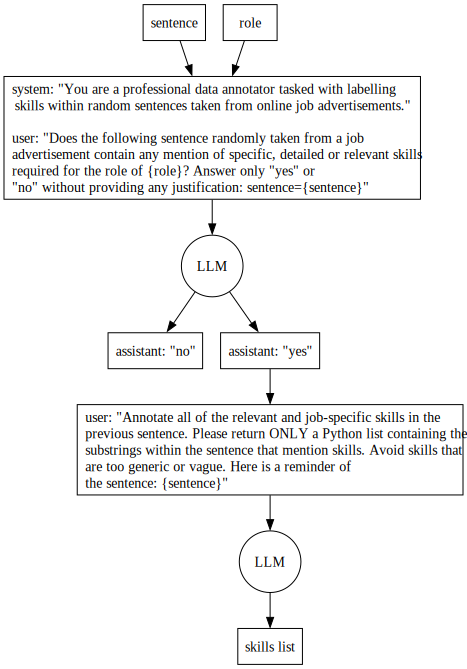

In [ ]:
#| echo: false
from graphviz import Digraph
from IPython.display import display
from graphviz import Source

dot = Digraph('PromptingLogic', node_attr={'shape': 'box'}, graph_attr={'ratio': 'fill'})

dot.node('A', 'sentence')
dot.node('B', 'role')

dot.node('C', 'system: "You are a professional data annotator tasked with labelling\lskills within random sentences taken from online job advertisements." \n\luser: "Does the following sentence randomly taken from a job \ladvertisement contain any mention of specific, detailed or relevant skills \lrequired for the role of {role}? Answer only "yes" or \l"no" without providing any justification: sentence={sentence}"\l')
dot.node('D', 'LLM', shape='circle')
dot.node('E', 'assistant: "no"')
dot.node('F', 'assistant: "yes"')
dot.node('G', 'user: "Annotate all of the relevant and job-specific skills in the \lprevious sentence. Please return ONLY a Python list containing the \lsubstrings within the sentence that mention skills. Avoid skills that \lare too generic or vague. Here is a reminder of \lthe sentence: {sentence}"\l')
dot.node('H', 'LLM', shape='circle')
dot.node('I', 'skills list')

# Define edges
dot.edges(['AC', 'BC', 'CD'])
dot.edges(['DE', 'DF'])
dot.edges(['FG'])
dot.edges(['GH'])
dot.edges(['HI'])

# dot.view()

src = Source(dot.source)
display(src)

This prompt chain could be represented in the following `label_skills_chain` function: 

In [ ]:
#| echo: true
def label_skills_chain(sentence: str, # sentence from job profile 
                 role: str # role title from job profile
                ) -> list:
    "Extracts skills from job profiles"
    chat_history = _init_chat_history(sentence, role)
    contains_skills, contains_skills_chat = _does_sentence_contain_skills(chat_history)  
    if not contains_skills:
        return []
    labelled_skills_chat, skills = _annotate_skills(contains_skills_chat, sentence)
    return skills

def _init_chat_history(sentence: str, # sentence from job profile
                       role: str # role title from job profile
                      ) -> list[dict]:
    "Construct initial chat prompt"
    return [
        {"role": "system", "content": "You are a professional data annotator tasked with labelling skills within random sentences taken from online job advertisements."},
        {"role": "user", "content": f"Does the following sentence randomly taken from a job advertisement contain any mention of specific, detailed and relevant skills required for the role of {role}? Answer only 'yes' or 'no' without providing any justification: sentence='{sentence}'"}
    ]

def _does_sentence_contain_skills(chat_history: list # list of prompts and responses
                                 ) -> Tuple[bool, List[dict]]:
    "Check if sentence contains any skills"
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=chat_history,
        temperature = 0.0
    )
    content = response["choices"][0]['message']["content"].lower()
    if 'yes' in content and 'no' not in content:
        chat_history.append({'role': 'assistant', 'content': 'yes.'})
        return True, chat_history
    else: 
        chat_history.append({'role': 'assistant', 'content': 'no.'})
        return False, chat_history

def _annotate_skills(chat_history: list, # "Construct initial chat prompt"
                     sentence: str) -> Tuple[List, List]:
    "Label all skills in sentence returning list of skill spans"
    annotation_prompt = {
        "role": "user",
        "content": f"Annotate all of the relevant and job-specific skills in the previous sentence. Please return ONLY a Python list containing the substrings within the sentence that mention skills. Avoid skills that are too generic or vague. Here is a reminder of the sentence: {sentence}"
    }
    chat_history.append(annotation_prompt)
    return _extract_skills_from_response(chat_history)

def _extract_skills_from_response(chat_history: list # list of prompts and responses
                                 ) -> Tuple[List, List]:
    "Extract skills from the model's response."
    attempt = 0
    temperature = 0
    # LLMs hallucinate and return output in myriad formats so we make 3 
    # attempts to extract list for varying temperatures
    while attempt < 3:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=chat_history,
            temperature=temperature
        )
        try:
            chat_history.append({'role': 'assistant', 'content': response['choices'][0]['message']["content"]})
            return chat_history, ast.literal_eval(response['choices'][0]['message']["content"])
        except SyntaxError:
            attempt += 1
            temperature += 0.2      
    return [], []

In [ ]:
#| echo: true
label_skills_chain("You should be able to program in python and cook a mean risotto", "Prompt Engineer")

['program in python', 'cook a mean risotto']

Lets annotate our favourite 'Prompt Engineer' job profile once more: 

In [ ]:
#| echo: false
gpt_prompt_results = []
for sentence in tqdm(sentences):
    gpt_prompt_results.append({'sentence': sentence, 'labels': label_skills_chain(sentence, role="Prompt Engineer")})   

In [ ]:
display_inference_results(gpt_prompt_results)

Of course we can also use LLMs to infer skills that don't exactly match any substrings in the original text. This is a much more flexible approach and opens up potential for more skills to be identified and a greater level of creativity: 

In [ ]:
def _annotate_skills(chat_history: list, # "Construct initial chat prompt"
                     role: str # role title from job profile
                    ):
    "Label all skills in sentence returning list of skill spans"
    annotation_prompt = {
        "role": "user",
        "content": f"Please return ONLY a Python list containing the unique skill requirements for the role of {role} that you can infer from this sentence. Only include skills that are unique, descriptive and essential for the role. If in doubt, do not include the skill."
    }
    chat_history.append(annotation_prompt)
    return _extract_skills_from_response(chat_history)

def label_skills_chain(sentence: str, # sentence from job profile 
                 role: str # role title from job profile
                ) -> List:
    "Extracts skills from job profiles"
    chat_history = _init_chat_history(sentence, role)
    contains_skills, contains_skills_chat = _does_sentence_contain_skills(chat_history)  
    if not contains_skills:
        return []
    labelled_skills_chat, skills = _annotate_skills(contains_skills_chat, role)
    return skills

In [ ]:
#| echo: false
from tqdm import tqdm
gpt_prompt_results = []
for sentence in tqdm(sentences):
    labels = label_skills_chain(sentence, role="Prompt Engineer")
    if labels:
        gpt_prompt_results.append({'sentence': sentence, 'labels': labels})   

In [ ]:
#| echo: false
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(gpt_prompt_results)

,sentence,labels
0,"You will figure out the best methods of prompting our AI to accomplish a wide range of tasks, then document these methods to build up a library of tools and a set of tutorials that allows others to learn prompt engineering, as well as work with high value partners to directly solve their challenges.","[figuring out best methods of prompting AI, documenting methods, building a library of tools, creating tutorials, working with high value partners, solving challenges]"
1,"Given that the field of prompt-engineering is arguably less than 2 years old, this position is a bit hard to hire for! As a result, we ask that you share with us a specific prompt engineering project on LLMs that you’re proud of in your application! Ideally this project should show off a complex and clever prompting architecture or a systematic evaluation of an LLM’s behavior.","[prompt engineering, working with LLMs, developing complex prompting architecture, systematic evaluation of an LLM’s behavior]"
2,"Our interdisciplinary team has experience across ML, physics, policy, business and product.","[ML, physics, policy, business, product]"
3,"Build up a library of high quality prompts or prompt chains to accomplish a variety of tasks, with an easy guide to help users search for the one that meets their needs.","[Building libraries of prompts, Creating prompt chains, Task accomplishment, Guide creation for user assistance, Understanding user needs]"
4,Build a set of tutorials and interactive tools that teach the art of prompt engineering to our customers.,"[Building tutorials, Creating interactive tools, Teaching prompt engineering]"
5,Have at least a high level familiarity with the architecture and operation of large language models.,"[high level familiarity with the architecture of large language models, high level familiarity with the operation of large language models]"
6,"Are an excellent communicator, and love teaching technical concepts and creating high quality documentation that helps out others.","[excellent communication, teaching technical concepts, creating high quality documentation]"
7,Have at least basic programming skills and would be comfortable writing small Python programs.,"[basic programming skills, writing small Python programs]"
8,"You anticipate unforeseen risks, model out scenarios, and provide actionable guidance to internal stakeholders.","[risk anticipation, scenario modelling, providing actionable guidance]"
9,"As such, we greatly value communication skills.",[communication skills]


GPT-4 has managed to synthesize skills from the text and rewrite them as action orientated, often removing determiners and splitting skills. `Build a set of tutorials and interactive tools` becomes `Building tutorials` and `Creating interactive tools`. We can easily recompose this prompt chain adding checking steps to further filter results. It is likely that we will continue to use a combination transformers for tasks like skill extraction leveraging prompt design and fine-tuning.

### Weirdos and Misfits Bonus Level 👾👾👾

We would be remiss if we didn't test our fine-tuned models and prompt chains on Dominic Cummings' [vintage job ad](https://dominiccummings.com/2020/01/02/two-hands-are-a-lot-were-hiring-data-scientists-project-managers-policy-experts-assorted-weirdos/).

![](assets/ten.jpeg)

Lets firstly attempt to pass the job profile through Roberta:

In [ ]:
#| echo: false
file_path = '../assets/cummings.txt'
weirdos = separate_text(file_path)

In [ ]:
#| echo: true
from transformers import pipeline

token_classifier = pipeline(
    "token-classification", model="autosyrup/roberta", tokenizer="autosyrup/roberta",
    ignore_labels=['O']
)

weirdo_roberta_results = run_inference_hf(weirdos, token_classifier)
display_inference_results(weirdo_roberta_results)

We notice the model picks up on `spread fake news about fake news` as the context may not be clear that whilst this is indeed a (useful) skill, it is undesirable in the opinion of the recruiter. Lets now extend our prompt-chain to include an explanation step where will get GPT-4 to attempt an explanation as to why it has or has not labelled a sentence with skills:

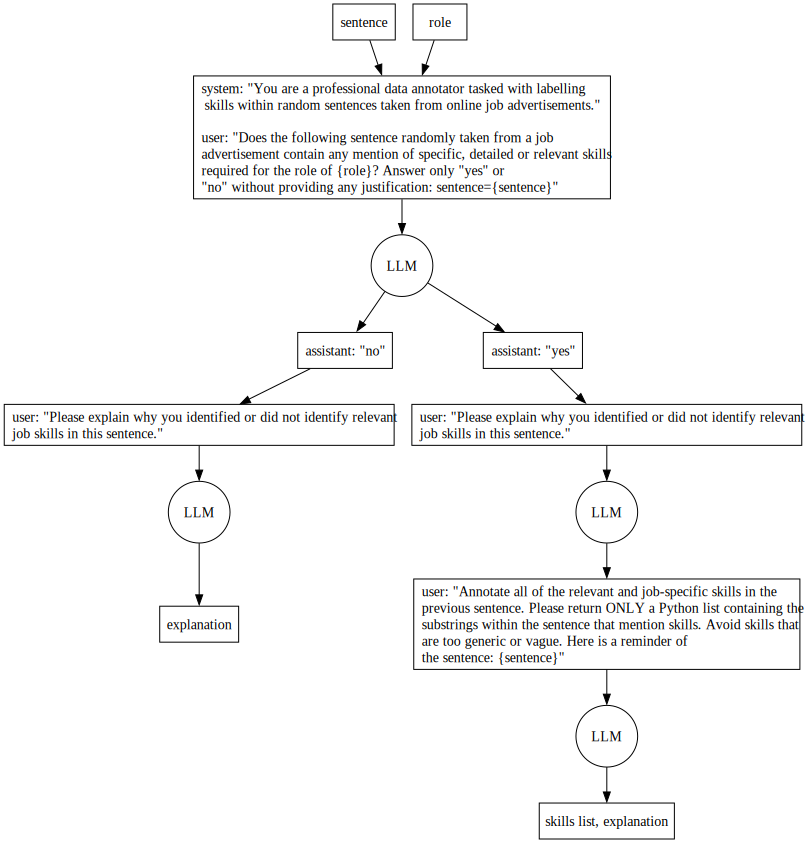

In [ ]:
#| echo: false
from graphviz import Digraph
from IPython.display import display
from graphviz import Source

dot = Digraph('PromptingLogic', node_attr={'shape': 'box'}, graph_attr={'ratio': 'fill'})

dot.node('A', 'sentence')
dot.node('B', 'role')

dot.node('C', 'system: "You are a professional data annotator tasked with labelling\lskills within random sentences taken from online job advertisements." \n\luser: "Does the following sentence randomly taken from a job \ladvertisement contain any mention of specific, detailed or relevant skills \lrequired for the role of {role}? Answer only "yes" or \l"no" without providing any justification: sentence={sentence}"\l')
dot.node('D', 'LLM', shape='circle')
dot.node('E', 'assistant: "no"')
dot.node('J', 'user: "Please explain why you identified or did not identify relevant \ljob skills in this sentence."\l')
dot.node('K', 'LLM', shape='circle')
dot.node('L', 'explanation')
dot.node('M', 'user: "Please explain why you identified or did not identify relevant \ljob skills in this sentence."\l')
dot.node('N', 'LLM', shape='circle')
dot.node('F', 'assistant: "yes"')
dot.node('G', 'user: "Annotate all of the relevant and job-specific skills in the \lprevious sentence. Please return ONLY a Python list containing the \lsubstrings within the sentence that mention skills. Avoid skills that \lare too generic or vague. Here is a reminder of \lthe sentence: {sentence}"\l')
dot.node('H', 'LLM', shape='circle')
dot.node('I', 'skills list, explanation')

# Define edges
dot.edges(['AC', 'BC', 'CD'])
dot.edges(['DE', 'DF'])
dot.edges(['GH'])
dot.edges(['HI'])
dot.edges(['EJ'])
dot.edges(['JK'])
dot.edges(['KL'])
dot.edges(['FM'])
dot.edges(['MN'])
dot.edges(['NG'])

# dot.view()

src = Source(dot.source)
display(src)

The above prompt chain could be represented as follows: 

In [ ]:
#| echo: true
def label_and_explain_skills_chain(sentence: str, # sentence from job profile 
                ) -> Tuple[List, str]:
    "Extracts skills from job profiles"
    chat_history = _init_chat_history(sentence)
    contains_skills, contains_skills_chat = _does_sentence_contain_skills(chat_history)
    explanation_chat, explanation = _explain_skills(contains_skills_chat)
    if not contains_skills:
        return [], explanation
    labelled_skills_chat, skills = _annotate_skills(explanation_chat)
    return skills, explanation
    
def _init_chat_history(sentence: str, # sentence from job profile
                      ) -> List[dict]:
    "Construct initial chat prompt"
    return [
        {"role": "system", "content": "You are a professional data annotator tasked with labelling skills within random sentences taken from online job advertisements."},
        {"role": "user", "content": f"Does the following sentence randomly taken from a job advertisement contain any mention of specific, detailed and relevant skills required for a job role? Answer only 'yes' or 'no' without providing any justification: sentence='{sentence}'"}
    ]
    
def _explain_skills(chat_history: list # "Construct initial chat prompt"
                   ) -> Tuple[List[dict], str]:
    "Force model to explain its labelling decisions"
    explanation_prompt = {
        "role": "user",
        "content": "Please explain why you identified or did not identify relevant job skills in this sentence."
    }
    chat_history.append(explanation_prompt)
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=chat_history,
        temperature = 0.0
        )
    explanation = response["choices"][0]['message']["content"]
    chat_history.append({"role": "assistant", "content": explanation})
    return chat_history, explanation

def _annotate_skills(chat_history: list, # "Construct initial chat prompt"
                    ):
    "Label all skills in sentence returning list of skill spans"
    annotation_prompt = {
        "role": "user",
        "content": f"Please return ONLY a Python list containing the unique skill requirements for a job role that you can infer from this sentence. Only include skills that could be unique, descriptive and essential for a job role. If in doubt, do not include the skill."
    }
    chat_history.append(annotation_prompt)
    return _extract_skills_from_response(chat_history)

For brevity we only run inference on the first ~10 sentences. We hope this demonstrates how simple it is to add additional steps for explainability or checking to an existing prompt chain:

In [ ]:
#| echo: false
from tqdm import tqdm
gpt_prompt_results = []
for sentence in tqdm(weirdos[0:11]):
    labels, explanation = label_and_explain_skills_chain(sentence)
    gpt_prompt_results.append({'sentence': sentence, 'labels': labels, 'explanation': explanation})   

In [ ]:
#| echo: false
pd.DataFrame(gpt_prompt_results)

,sentence,labels,explanation
0,There are many brilliant people in the civil service and politics.,[],"The sentence does not mention any specific, detailed, or relevant skills required for a job role. It only makes a general statement about the people in the civil service and politics, without specifying any particular skills or abilities they might have."
1,Over the past five months the No10 political team has been lucky to work with some fantastic officials.,[],"The sentence does not mention any specific, detailed, or relevant skills required for a job role. It only talks about the experience of the No10 political team working with some officials, but it does not specify what skills are needed or were used."
2,But there are also some profound problems at the core of how the British state makes decisions.,[],"The sentence does not mention any specific, detailed, or relevant skills required for a job role. It is a general statement about decision-making in the British state, but does not specify any particular skills or abilities that a job candidate should possess."
3,This was seen by pundit-world as a very eccentric view in 2014.,[],"The sentence ""This was seen by pundit-world as a very eccentric view in 2014."" does not mention any specific, detailed, or relevant skills required for a job role. It seems to be a statement about a viewpoint or opinion, rather than a description of job skills or qualifications."
4,It is no longer seen as eccentric.,[],"The sentence ""It is no longer seen as eccentric."" does not mention any specific, detailed, or relevant skills required for a job role. It is a general statement and does not provide any information about job requirements or qualifications."
5,"Dealing with these deep problems is supported by many great officials, particularly younger ones, though of course there will naturally be many fears — some reasonable, most unreasonable.",[],"The sentence does not mention any specific, detailed, or relevant skills required for a job role. It talks about dealing with problems and mentions officials, but it does not specify what skills are needed to deal with these problems or to be an official."
6,"Now there is a confluence of: a) Brexit requires many large changes in policy and in the structure of decision-making, b) some people in government are prepared to take risks to change things a lot, and c) a new government with a significant majority and little need to worry about short-term unpopularity while trying to make rapid progress with long-term problems.",[],"The sentence does not identify any relevant job skills because it is discussing political and governmental circumstances, not specifying any particular skills or abilities needed for a job role."
7,"There is a huge amount of low hanging fruit — trillion dollar bills lying on the street — in the intersection of:\n\nthe selection, education and training of people for high performance\nthe frontiers of the science of prediction\ndata science, AI and cognitive technologies (e.g Seeing Rooms, ‘authoring tools designed for arguing from evidence’, Tetlock/IARPA prediction tournaments that could easily be extended to consider ‘clusters’ of issues around themes like Brexit to improve policy and project management)\ncommunication (e.g Cialdini)\ndecision-making institutions at the apex of government.","[education and training for high performance, knowledge in the science of prediction, data science, AI and cognitive technologies, communication skills, experience with decision-making institutions at the apex of government]","The sentence mentions several relevant job skills such as education and training for high performance, knowledge in the science of prediction, data science, AI and cognitive technologies, communication skills, and experience with decision-making institutions at the apex of government."
8,"We want to hire an unusual set of people with different skills and backgrounds to work in Downing Street with the best officials, s